### *Hong Sraer (2016),  "Speculative Betas"*

*Data retrieved from Prof. Sraer's website at http://faculty.haas.berkeley.edu/dsraer/data.html*

Loading .dta files (from stata) into python/pandas and creating date index that is useful for plotting.

In [47]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import numpy as np
data20 = pd.io.stata.read_stata('portfolios/20_beta_sorted_portfolios.dta')
data40 = pd.io.stata.read_stata('portfolios/20_beta_sorted_portfolios.dta')
data20['date'] = data20.apply(lambda x: str(int(x['year'])) + '/' + str(int(x['month'])), axis=1)
data40['date'] = data40.apply(lambda x: str(int(x['year'])) + '/' + str(int(x['month'])), axis=1)
data20.set_index('date', inplace=True)
data40.set_index('date', inplace=True)



In [48]:
# Defining lagged variables from data
lags = [3,6,9,12,18]
for lag in lags:
     data20['mktrf_lag' + str(lag)] = data20['mktrf'].shift(lag)


We couldnt get BETA_1 variable, the post-ranking full sample beta of each portfolio. Attempting to reconstruct it from the data below. However, data uses daily returns to compute the beta, whereas we have monthly results. Spread is still extremely wide, and results are similar for all but the bottom two portfolios (compare with descriptive statistics on Table 1 of paper).

In [49]:
def get_beta(df):
    '''
    df: dataframe for each group, ranked by betas. 
    '''
    # Regressing portfolio returns on the current and lagged market returns
    # Ran first controlling for serial correlation and heteroskedasticity using newey-west std errors
    # Results were similar than just the usual OLS, so left it as is (also no specification in paper).

#### RESULTS USING NEWEY WEST    
#     results = sm.ols(formula="ret_rf ~ mktrf + mktrf_lag3 + mktrf_lag6 + mktrf_lag9 + mktrf_lag12 + mktrf_lag18", 
#                      data=df).fit(cov_type='HAC',cov_kwds={'maxlags':17})
    
    results = sm.ols(formula="ret_rf ~ mktrf + mktrf_lag3 + mktrf_lag6 + mktrf_lag9 + mktrf_lag12 + mktrf_lag18", 
                 data=df).fit()

    params = results.params
    # Beta computed as sum of the coefficients of all lags of market returns, per the paper
    out = params[1:].sum()
    return(out)
    
# Full sample postranking betas computed, so we just need to groupby portfolios and do regression
betas = data20.groupby('group').apply(lambda x: get_beta(x))
betas_df = pd.DataFrame(betas).rename(columns={0: "BETA_1"})
betas_df
data20 = data20.merge(betas_df, how='left', left_on=['group'], right_index=True)
data20['BETA_2'] = data20['BETA_1'].pow(2)


Displaying betas for each group

In [50]:
betas_display = pd.DataFrame({'Betas': data20['BETA_1'].unique()})
betas_display.index = range(1,21)
betas_display

,Betas
1,0.159782
2,0.251669
3,0.400479
4,0.550107
5,0.557424
6,0.624215
7,0.677083
8,0.672397
9,0.809993
10,0.808146


### Replicating figure 6

0 = Low
1 = Mid
2 = High

In [51]:
quartiles = data20['aggregate_disp_daily'].quantile([.25,.75])
low_q = quartiles.loc[.25]
high_q = quartiles.loc[.75]
data20['boolean_disagreement'] = 1
data20['boolean_disagreement'] = np.where(data20['aggregate_disp_daily'] <= low_q, 0, data20['boolean_disagreement'])
data20['boolean_disagreement'] = np.where(data20['aggregate_disp_daily'] >= high_q, 2, data20['boolean_disagreement'])


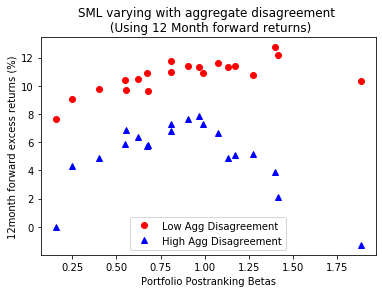

In [80]:
def figure6(df, var):
    avg = df[var].mean()
    return(avg)

# lags = ['3', '6', '12', '18']
lags = ['12']
for lag in lags:
    var = 'ret_rf' + lag
    fig6_totalDF = data20.groupby(['BETA_1', 'boolean_disagreement']).apply(lambda x: figure6(x, var)).reset_index()
    fig6_totalDF = fig6_totalDF.loc[fig6_totalDF['boolean_disagreement'] != 1]
    fig6_totalDF = fig6_totalDF.rename(columns = {0: 'AvgRet_'+ lag})
    
    # Plotting
    groups = fig6_totalDF.groupby('boolean_disagreement')
    fig, ax = plt.subplots()
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    labelDict = {0: 'Low Agg Disagreement', 2: 'High Agg Disagreement'}
    colorDict = {0: 'red', 2: 'blue'}
    markerDict = {0: 'o', 2: '^'}
    
    for name, group in groups:
        ax.plot(group['BETA_1'], group['AvgRet_'+ lag], marker=markerDict[name], linestyle='', 
                color=colorDict[name] ,label=labelDict[name])
    ax.set_ylabel(lag + 'month forward excess returns (%)')
    ax.set_xlabel('Portfolio Postranking Betas')
    ax.set_title('SML varying with aggregate disagreement \n (Using 12 Month forward returns)')
    ax.legend()


While the relationship between excess forward returns and β is quite noisy
at the 3- and 6-month horizons, two striking facts emerge at the 12- and
18-month horizons. First, the average excess returns-to-β relationship is mostly
upward-sloping for months with low aggregate disagreement. This result is generally consistent with our theory, which holds that low aggregate disagreement
means low or even no mispricing and hence a strictly upward-sloping Security
Market Line. Second, in months of high aggregate disagreement, the excess
returns-to-β relationship appears to exhibit the inverted-U shape predicted by
the theory.

## Regression results

First, we estimate first stage cross-sectional regression over 20 $\beta$ sorted portfolios:
$$r^{(12)}_{P,t} = \kappa_t + \pi_t \cdot \beta_P + \phi_t \cdot (\beta_P)^2 + \epsilon_{P,t}$$
$$For:  P = {1,2,...,20}$$

$r^{(12)}_{P,t}$ is the 12-month excess return of the $P^{th}$ beta-sorted portfolio, and $\beta_P$ is the full-sample post-ranking beta of that portfolio.

You will get a time series of $\kappa_t$, $\pi_t$, and $\phi_t$, for each month's regression. We are mostly interested in time series of $\phi_t$ which represents concavity of SML. 

Essentially, we want to perform a time-series regression of $\phi_t$ on aggregate disagreement and other control covariates (as suggested by literature), and see how this determines it.

In [81]:
def regTable3(df):
    try:
        results = sm.ols(formula="ret_rf12 ~ BETA_1 + BETA_2", data=df).fit()
        params = results.params
        params.index = ['slope0', 'slope1', 'slope2']
    except:
        params = pd.Series([np.nan]*3)
        params.index = ['slope0', 'slope1', 'slope2']
    return(params)

coeffs = data20.reset_index().groupby(['month', 'year']).apply(lambda x: regTable3(x)).reset_index()
coeffs['date'] = coeffs.apply(lambda x: str(int(x['year'])) + '/' + str(int(x['month'])), axis=1)
coeffs = coeffs.set_index('date').drop(['month', 'year'], axis=1)
data20 = data20.merge(coeffs, how='left', left_index=True, right_index=True)


Now, we perform second stage regression as explained above. We use Newey West estimators for the standard errors while still using OLS -- no reason to think regressor endogeneity is present, so OLS estimators are still unbiased/consistent. However, we need to use NW std errors, which are heteroskedasticity and auto-correlation robust, to properly perform inference.

#### ADD DERIVTION OF NEWEY WEST COVARIANCE MATRIX vs. USUAL OLS W/ HOMOSKEDASTICITY COVARIANCE MATRIX

In [121]:
# Creating lagged variable of agg disp
data20['aggregate_disp_lag1'] = data20.groupby('group')['aggregate_disp_daily'].shift(1)

# Scaling and lagging necessary variables
scaleVars = ['dp', 'TED','inflation']
for var in scaleVars:
    newVar = var+'_scaled_lag1'
    data20[newVar] = data20.groupby('group')[var].shift(1)
    data20[newVar] = data20[newVar].sub(data20[newVar].mean()).div(data20[newVar].std())



Index(['group', 'year', 'month', 'ret_rf', 'ret_rf1', 'ret_rf3', 'ret_rf6',
       'ret_rf9', 'ret_rf12', 'ret_rf18', 'inflation', 'TED', 'dp', 'pe',
       'mktrf', 'smb', 'hml', 'umd', 'aggregate_disp_daily', 'mktrf_1',
       'mktrf_3', 'mktrf_6', 'mktrf_9', 'mktrf_12', 'mktrf_18', 'hml_1',
       'hml_3', 'hml_6', 'hml_9', 'hml_12', 'hml_18', 'smb_1', 'smb_3',
       'smb_6', 'smb_9', 'smb_12', 'smb_18', 'umd_1', 'umd_3', 'umd_6',
       'umd_9', 'umd_12', 'umd_18', 'mktrf_lag3', 'mktrf_lag6', 'mktrf_lag9',
       'mktrf_lag12', 'mktrf_lag18', 'BETA_1', 'BETA_2',
       'boolean_disagreement', 'slope0', 'slope1', 'slope2',
       'aggregate_disp_lag1', 'aggregate_disp_lag1_scaled', 'dp_scaled_lag1',
       'TED_scaled_lag1', 'inflation_scaled_lag1'],
      dtype='object')

In [143]:
def regFunc(big_df, varList):
    '''
    Params
    1) big_df: Dataframe with all variables, regardless of specification
    2) varList: list with variables, and last element is dependent variable (y)
    '''
    df = big_df[varList]
    
    # Automating parameter to be passed to sm.ols()
    formula_str = varList[-1] + '~' + varList[0]
    if len(varList) > 1:
        for regressor in varList[1:-1]:
            formula_str = formula_str + '+' + regressor
    
    # Computing regression object
    results = sm.ols(formula=formula_str, data=df).fit(cov_type='HAC',cov_kwds={'maxlags':11})
    return(results.summary())
    

specMax = ['aggregate_disp_lag1', 'mktrf_12', 'hml_12', 'smb_12', 'umd_12', 'dp_scaled_lag1', 'inflation_scaled_lag1',
          'TED_scaled_lag1']
regDict = {'Spec1': specMax[0],
           'Spec2': specMax[:5],
           'Spec3': specMax[:-1],
           'Spec4': specMax}

# Reducing data matrix to relevant variables of interest, 
# and dropping duplicates as these variables are common across portfolios

regDF = data20[['slope2'] + specMax].dropna()
regDF = regDF.drop_duplicates()

regResults = []
for key, value in regDict.items():
#     print('Regressing spefication: ' + key)
#     print('Regressors:', value)
    allVars = [value] + ['slope2'] if key == 'Spec1' else value + ['slope2']
    regResults.append(regFunc(regDF, allVars))
    

Regressing spefication: Spec1
Regressors: aggregate_disp_lag1
Regressing spefication: Spec2
Regressors: ['aggregate_disp_lag1', 'mktrf_12', 'hml_12', 'smb_12', 'umd_12']
Regressing spefication: Spec3
Regressors: ['aggregate_disp_lag1', 'mktrf_12', 'hml_12', 'smb_12', 'umd_12', 'dp_scaled_lag1', 'inflation_scaled_lag1']
Regressing spefication: Spec4
Regressors: ['aggregate_disp_lag1', 'mktrf_12', 'hml_12', 'smb_12', 'umd_12', 'dp_scaled_lag1', 'inflation_scaled_lag1', 'TED_scaled_lag1']


In [147]:
regResults

[<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                 slope2   R-squared:                       0.098
 Model:                            OLS   Adj. R-squared:                  0.095
 Method:                 Least Squares   F-statistic:                     4.350
 Date:                Thu, 28 Nov 2019   Prob (F-statistic):             0.0377
 Time:                        14:23:40   Log-Likelihood:                -1515.3
 No. Observations:                 384   AIC:                             3035.
 Df Residuals:                     382   BIC:                             3043.
 Df Model:                           1                                         
 Covariance Type:                  HAC                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------

**Results presented above from the second-stage regressions.**

A higher Agg.Disp.t−1 is associated with a
smaller φt, that is, a more concave Security Market Line, or equivalently, lower
average returns of the square portfolio. The t-statistics are between −2.1 and
−3.7 depending on the specification. Importantly, the estimate is significant by
itself even without any controls, although the inclusion of the D/P ratio and
the year-over-year past inflation rate increases the effect of aggregate disagreement on the concavity of the Security Market Line

## Additional Plots

### 1) Showing time series of SML concavity coeff and agg Disagreement

RELEVANT: Note period during dotcom bubble

Text(0.5, 1.0, 'Time Series of Concavity vs Aggregate Disagreement')

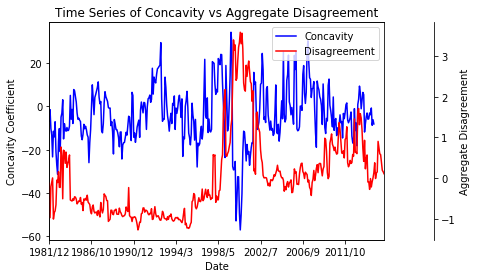

In [161]:
plot1_df = data20[['slope2', 'aggregate_disp_daily']].drop_duplicates()

fig, ax = plt.subplots()
ax2 = ax.twinx()
rspine = ax2.spines['right']
rspine.set_position(('axes', 1.15))

plot1_df.slope2.plot(ax=ax, style='b-')
plot1_df.aggregate_disp_daily.plot(ax=ax2, style='r-')
ax2.legend([ax.get_lines()[0], ax2.get_lines()[0]], ['Concavity','Disagreement'])

ax.set_xlabel('Date')
ax.set_ylabel('Concavity Coefficient')
ax2.set_ylabel('Aggregate Disagreement')
ax.set_title('Time Series of Concavity vs Aggregate Disagreement')


### 2) Show plot of diasgreement vs concavity, and add fitted values from regression (Figure 3 in draft paper)

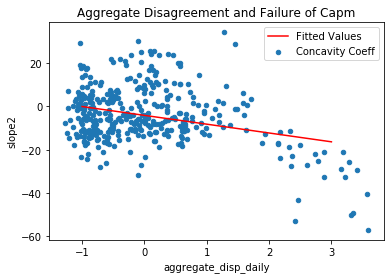

In [174]:
plot2_df = data20[['slope2', 'aggregate_disp_daily']].drop_duplicates()
fig,ax = plt.subplots()
plot2_df.plot.scatter(x='aggregate_disp_daily', y='slope2', ax=ax)
f = lambda x: -4.1048 + -4.0734*x
ax.plot([-1, 3], [f(-1), f(3)], c='r')    
ax.set_title('Aggregate Disagreement and Failure of Capm')
ax.legend(['Fitted Values','Concavity Coeff'])
